# Transfer learning

Let's try to use AlexNet model first to help us in the Rock-Paper-Scissors problem. We'll need to load AlexNet, with it's weights, then make a feature-extractor on our data loaders, modify the last layer, and train. Let's get to it: 

In [ ]:
#|code-fold: true
#|output: false
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop, InterpolationMode
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
from torchvision.models import Inception_V3_Weights, AlexNet_Weights
from torch.hub import load_state_dict_from_url

from torchviz import make_dot

from data_generation.rps import download_rps
from pytorched.step_by_step import StepByStep

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load AlexNet

We can get AlexNet from torchvision.models:

In [ ]:
weights = AlexNet_Weights.IMAGENET1K_V1
alex = alexnet(weights=weights)
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We need an original transform:

In [ ]:
transform = weights.transforms()

Let's now create new data loaders based on this transform:


In [ ]:
#|code-fold: true 
#|output: false
download_rps()

rps folder already exists!
rps-test-set folder already exists!


In [ ]:
train_dataset = ImageFolder(root='rps', transform=transform)
val_dataset = ImageFolder(root='rps-test-set', transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16)

Let's also define an optimizer and loss:

In [ ]:
torch.manual_seed(17)
optimizer = optim.Adam(alex.parameters(), 3e-4)
loss_fn = nn.CrossEntropyLoss()
sbs = StepByStep(alex, optimizer, loss_fn)

# Make a feature-extractor on our data loaders


We must freeze the model and then pass our loaders to generate new preprocessed datasets. These are our trainable parameters:

In [ ]:
sbs.print_trainable_parameters()

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


And these are suggestions what layers to change (of course more layers can be left unfrozen but this requires more training data and longer times):

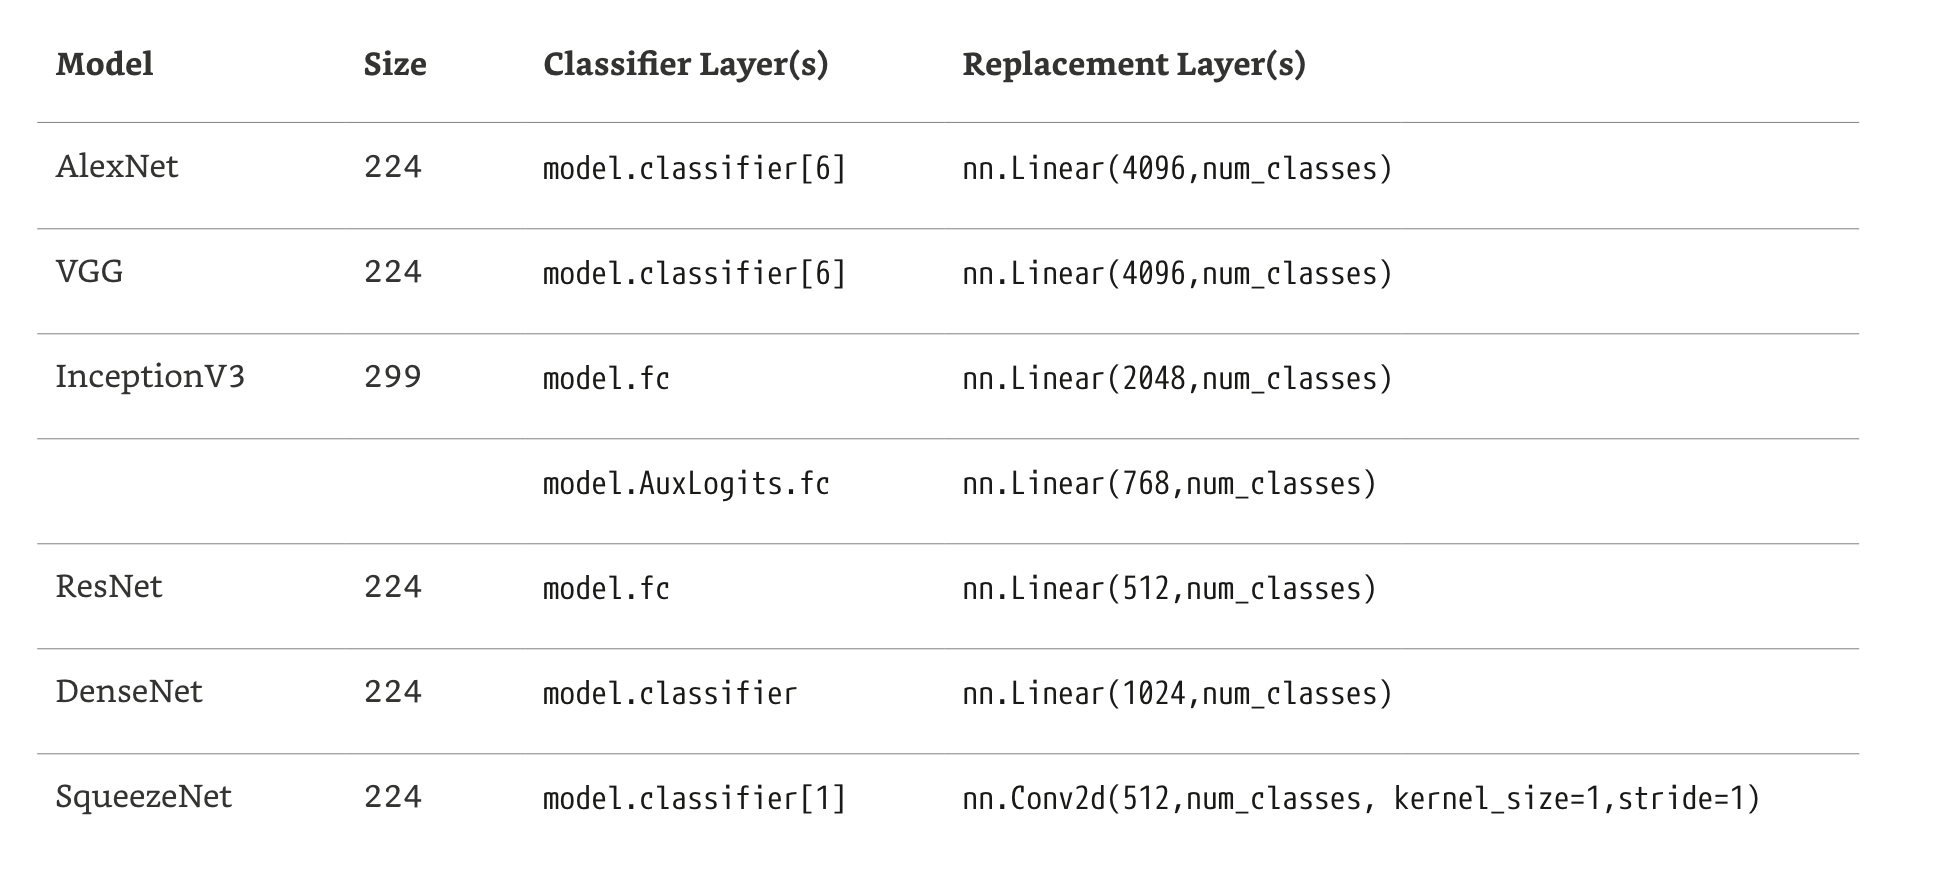

In [ ]:
sbs.model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
sbs.model.classifier[6] = nn.Identity()

TODO to continue

# Modify the last layer

# Train